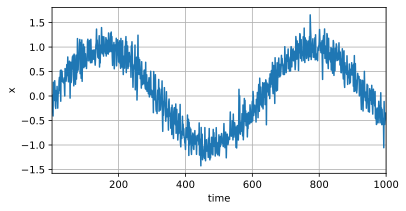

In [30]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,)) # 使用正弦函数和一些可加性噪声来生成序列数据
# print(torch.sin(0.01 * time))
# print(torch.normal(0, 0.2, (T,)))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [32]:
# 使用马尔科夫假设
# print(x)
tau = 4
features = torch.zeros((T - tau, tau)) # (样本, 特征)
print(features.shape) # (996, 4)
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
# print(features)
labels = x[tau:].reshape((-1, 1))
print(labels.shape)
batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

torch.Size([996, 4])
torch.Size([996, 1])


In [33]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [34]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            # l = nn.MSELoss(net(X), y)
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.067723
epoch 2, loss: 0.062813
epoch 3, loss: 0.057801
epoch 4, loss: 0.060578
epoch 5, loss: 0.056657


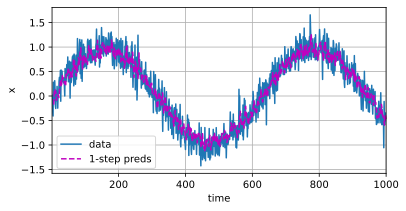

In [36]:
onestep_preds = net(features) # 使用已训练的net进行单步预测, net中的参数已经被训练好了
# print(features)
# print(onestep_preds)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

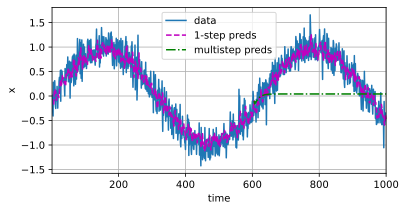

In [44]:
# 这里其实是用预测的值不断地作为输入来生成后续的预测值
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau] # 0到604

for i in range(n_train + tau, T): # 605到999
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

torch.Size([933, 68])


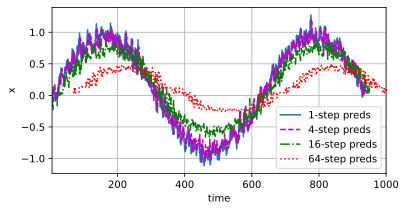

In [53]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
print(features.shape)
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))